# Blogcatalog friendship network

In [1]:
import networkx as nx
import numpy as np
import pickle as p
from os import path
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib import pyplot as plt
%matplotlib inline

data_loc = './../data/raw/BlogCatalog-dataset/data/'

BlogCatalog is the social blog directory which manages the bloggers and their blogs. There are 10,312 bloggers with unique ids starting from 1 to 10,312 and 333,983 friendship pairs in this dataset. Each blogger belongs to multiple groups. There are 39 groups with indices ranging from 1 to 39. 

## Load data from edge list

In [2]:
def maybe_load_data(data='./../data/blogcatalog.data'):
    if path.exists(data):
        print("Dataset is found. Skip reading...")
        with open(data, 'rb') as f:
            return p.load(f)
    else:
        iid = {}
        idx = 0
        edgelist = []

        # Read edges pairs
        with open(data_loc+'edges.csv', 'r') as f:
            for line in f.readlines():
                i, j = line.strip().split(',')  # csv
                if i not in iid:
                    iid[i] = idx; idx += 1
                if j not in iid:
                    iid[j] = idx; idx += 1
                edgelist.append((iid[i], iid[j]))

        # Create an nx undirected network
        bc = nx.Graph(edgelist)

        print("Number of nodes: ", len(bc))
        print("Number of edges: ", bc.size())
    
        # Read labels
        lil_labels = lil_matrix((len(bc), 39), dtype=int)
        # Read (node_id, label) file
        with open(data_loc+'group-edges.csv', 'r') as f:
            for line in f.readlines():
                node, group = line.strip().split(',') 
                lil_labels[iid[node], int(group) - 1] = 1  # range(0,39)
        
        # Pack data
        bc_dataset = {'NXGraph': bc, 'LILLabels': lil_labels}
        with open('./../data/blogcatalog.data', 'wb') as f:
            p.dump(bc_dataset, f)
        return bc_dataset

bc_dataset = maybe_load_data()

Dataset is found. Skip reading...


## Load labels as a sparse matrix

In the original dataset, the group index is in range 1 to 39. For computational convenient, I will convert the group ids to range 0-38.

In [3]:
labels = bc_dataset['LILLabels']

## Dump as edgelist

Graph with new ids is needed for other algorithms.

In [4]:
if not path.exists('./../data/blogcatalog.edges'):
    nx.write_edgelist(bc, path='./../data/blogcatalog.edges', data=False)
else:
    print("Edge list file is found. Skip writing...")

Edge list file is found. Skip writing...


## Graph analysis

### Degree distribution

In [5]:
b = bc_dataset['NXGraph']

In [7]:
degree_list = sorted([b.degree(i) for i in b], reverse=True)

Degree statistics:

In [10]:
print("Maximum degree: {}".format(degree_list[0]))
print("Minimum degree: {}".format(degree_list[-1]))
print("Mean of degree distribution: {}".format(np.mean(degree_list)))
print("Std variation of degree distribution: {}".format(np.std(degree_list)))

Maximum degree: 3992
Minimum degree: 1
Mean of degree distribution: 64.7756012412723
Std variation of degree distribution: 177.6973696826509


Degree distribution plot:

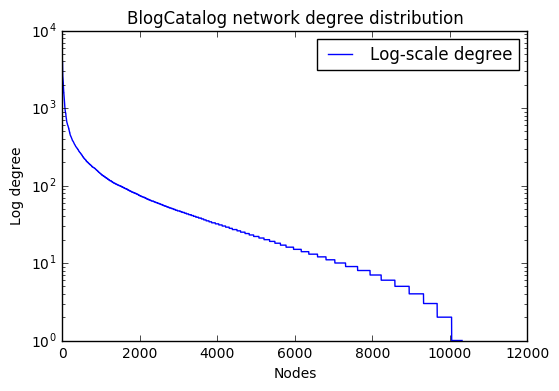

In [22]:
plt.subplot(111)
plt.semilogy(degree_list)
plt.title("BlogCatalog network degree distribution")
plt.ylabel("Log degree")
plt.xlabel("Nodes")
plt.legend(["Log-scale degree"])

In [ ]:
from os import path
path.append('./../src/')
from walks import WalkGenerator
from constrains import R, UTriangle, UWedge